In [80]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from PIL import Image
import imagehash
from itertools import combinations
from sklearn.model_selection import GroupShuffleSplit
import torchvision.transforms as T
from random import choice

In [9]:
def compute_stats(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    stats = {}


    stats['mean_R'] = img_rgb[:, :, 0].mean()
    stats['mean_G'] = img_rgb[:, :, 1].mean()
    stats['mean_B'] = img_rgb[:, :, 2].mean()

    stats['std_R'] = img_rgb[:, :, 0].std()
    stats['std_G'] = img_rgb[:, :, 1].std()
    stats['std_B'] = img_rgb[:, :, 2].std()


    stats['brightness'] = img_rgb.mean()


    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    stats['contrast'] = gray.std()


    s_channel = img_hsv[:, :, 1]
    sat_clip_ratio = np.sum(s_channel >= 255) / s_channel.size
    stats['saturation_clipping'] = sat_clip_ratio

    return stats


In [31]:
root_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"

image_paths = []
labels = []

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(root, file)

            label = os.path.basename(os.path.dirname(os.path.dirname(full_path)))
            image_paths.append(full_path)
            labels.append(label)

print(f"Total images found: {len(image_paths)}")

# Count images per class
class_counts = Counter(labels)
print("Images per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Total images found: 375
Images per class:
urooj: 125
Dilkash: 125
Akbar: 125


# (I)

In [10]:
data = []

for path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
    stats = compute_stats(path)
    stats['image'] = os.path.basename(path)
    stats['label'] = label
    data.append(stats)

df = pd.DataFrame(data)
df.head()


100%|██████████| 375/375 [00:05<00:00, 70.26it/s]


mean_R      mean_G      mean_B      std_R      std_G      std_B  \
0  142.518188  135.395218  138.254105  13.274088  13.493198  12.050873   
1  129.146133  120.425125  124.745514  13.515554  13.911088  12.382867   
2  129.982239  120.589966  122.808441  20.303549  19.850089  15.633741   
3  156.950180  148.517456  149.861389  12.685268  12.512701  11.193589   
4  122.222427  112.732712  117.060196  12.777843  12.322072   9.373987   

   brightness   contrast  saturation_clipping             image  label  
0  138.722504  13.141097                  0.0             a.jpg  urooj  
1  124.772257  13.549194                  0.0             a.jpg  urooj  
2  124.460215  19.353951                  0.0  urooj1 (244).jpg  urooj  
3  151.776342  12.259666                  0.0  urooj1 (253).jpg  urooj  
4  117.338445  12.004819                  0.0             a.jpg  urooj

In [12]:
class_stats = df.groupby('label').mean(numeric_only=True)
print(class_stats)


             mean_R      mean_G      mean_B      std_R      std_G      std_B  \
label                                                                          
Akbar    119.889125  115.493878  104.553976  30.401622  27.630631  20.368898   
Dilkash  126.718914  117.372677  120.861872  15.059425  14.541384  11.765767   
urooj    129.704429  120.990540  124.383990  15.124374  14.946499  12.512849   

         brightness   contrast  saturation_clipping  
label                                                
Akbar    113.312327  27.371944         5.584717e-04  
Dilkash  121.651154  14.214068         0.000000e+00  
urooj    125.026319  14.587935         1.220703e-07  


**Histogram by class based on RGB**

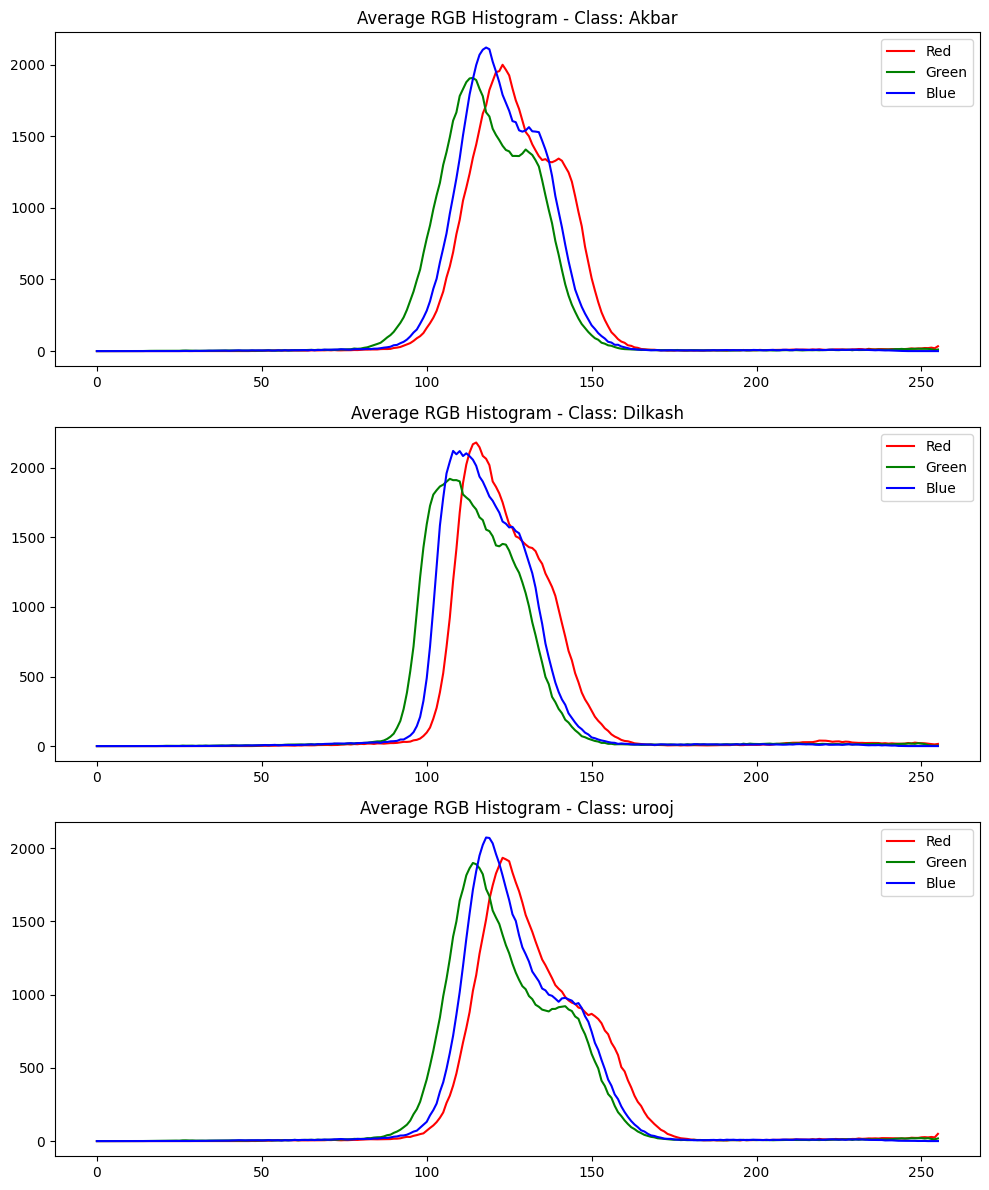

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


class_names = sorted(df['label'].unique())

fig, axes = plt.subplots(len(class_names), 1, figsize=(10, 4 * len(class_names)))


for i, cls in enumerate(class_names):

    cls_images = df[df['label'] == cls]['image'].values
    cls_paths = [p for p in image_paths if os.path.basename(p) in cls_images]

    hist_r = np.zeros(256)
    hist_g = np.zeros(256)
    hist_b = np.zeros(256)

    sample_paths = cls_paths[:10]

    for path in sample_paths:
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        hist_r += cv2.calcHist([img_rgb], [0], None, [256], [0, 256]).flatten()
        hist_g += cv2.calcHist([img_rgb], [1], None, [256], [0, 256]).flatten()
        hist_b += cv2.calcHist([img_rgb], [2], None, [256], [0, 256]).flatten()


    hist_r /= len(sample_paths)
    hist_g /= len(sample_paths)
    hist_b /= len(sample_paths)


    axes[i].plot(hist_r, color='r', label='Red')
    axes[i].plot(hist_g, color='g', label='Green')
    axes[i].plot(hist_b, color='b', label='Blue')
    axes[i].set_title(f'Average RGB Histogram - Class: {cls}')
    axes[i].legend()


plt.tight_layout()
plt.show()


**Histogram by class based on brightness**

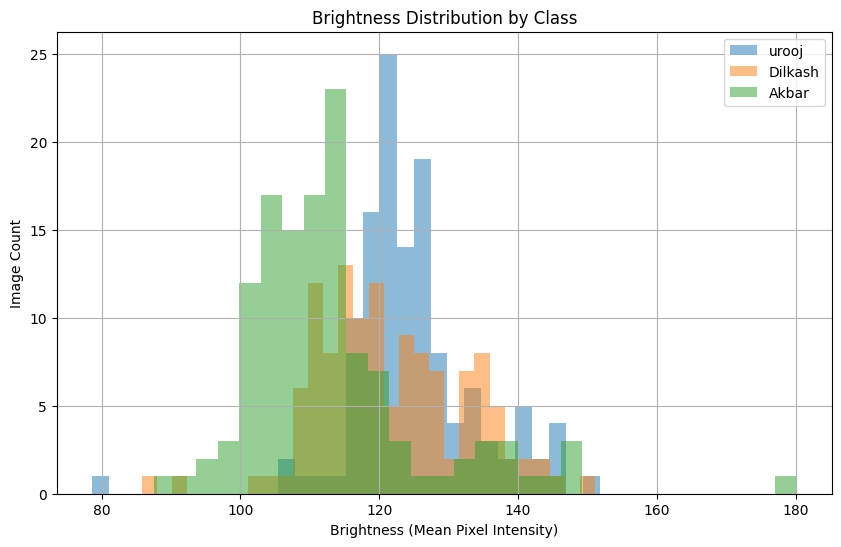

In [19]:
plt.figure(figsize=(10, 6))

for cls in df['label'].unique():
    subset = df[df['label'] == cls]
    plt.hist(subset['brightness'], bins=30, alpha=0.5, label=cls)

plt.title('Brightness Distribution by Class')
plt.xlabel('Brightness (Mean Pixel Intensity)')
plt.ylabel('Image Count')
plt.legend()
plt.grid(True)
plt.show()


**Histogram by class based on contrast**

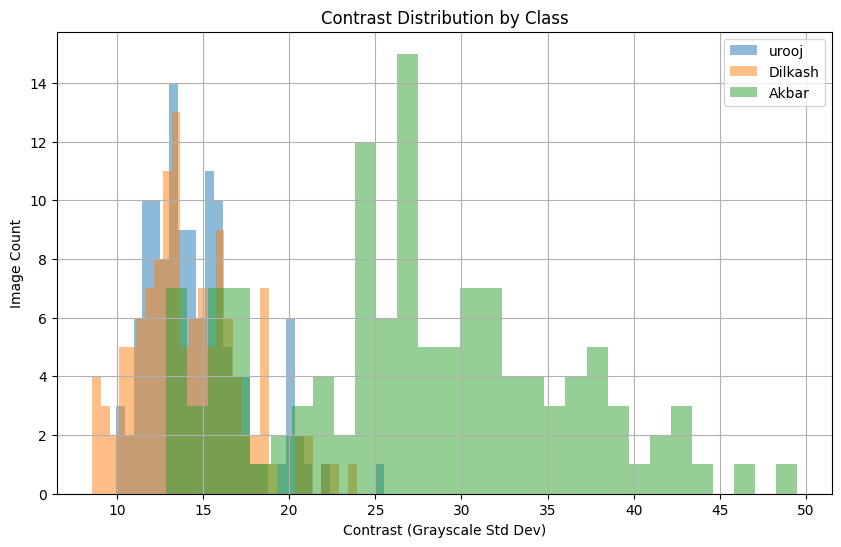

In [20]:
plt.figure(figsize=(10, 6))

for cls in df['label'].unique():
    subset = df[df['label'] == cls]
    plt.hist(subset['contrast'], bins=30, alpha=0.5, label=cls)

plt.title('Contrast Distribution by Class')
plt.xlabel('Contrast (Grayscale Std Dev)')
plt.ylabel('Image Count')
plt.legend()
plt.grid(True)
plt.show()


**Histogram by class based on Saturation clipping**

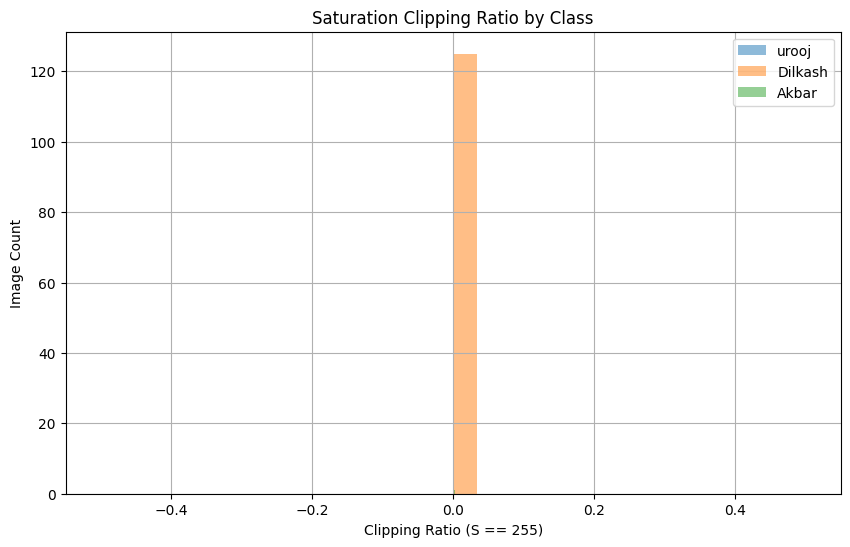

In [21]:
plt.figure(figsize=(10, 6))

for cls in df['label'].unique():
    subset = df[df['label'] == cls]
    plt.hist(subset['saturation_clipping'], bins=30, alpha=0.5, label=cls)

plt.title('Saturation Clipping Ratio by Class')
plt.xlabel('Clipping Ratio (S == 255)')
plt.ylabel('Image Count')
plt.legend()
plt.grid(True)
plt.show()


**Brightest and Darkest image**

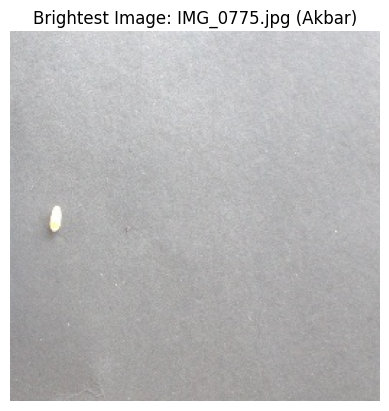

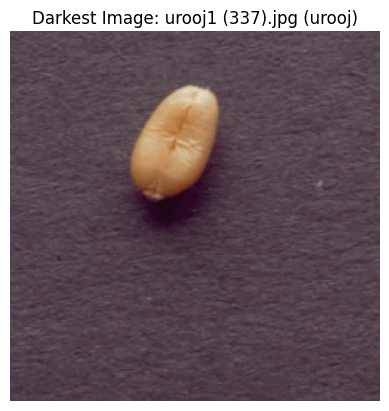

In [17]:
brightest = df.sort_values('brightness', ascending=False).iloc[0]
darkest = df.sort_values('brightness', ascending=True).iloc[0]

def show_image(path, title):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

bright_path = [p for p in image_paths if brightest['image'] in p][0]
dark_path = [p for p in image_paths if darkest['image'] in p][0]

show_image(bright_path, f"Brightest Image: {brightest['image']} ({brightest['label']})")
show_image(dark_path, f"Darkest Image: {darkest['image']} ({darkest['label']})")


# (II)

In [22]:
widths = []
heights = []
aspect_ratios = []
labels_list = []

for path in image_paths:
    img = cv2.imread(path)
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)
    

    filename = os.path.basename(path)
    label = df.loc[df['image'] == filename, 'label'].values[0]
    labels_list.append(label)

res_df = pd.DataFrame({
    'filename': [os.path.basename(p) for p in image_paths],
    'width': widths,
    'height': heights,
    'aspect_ratio': aspect_ratios,
    'label': labels_list
})


**Histogram by class based on resolution**

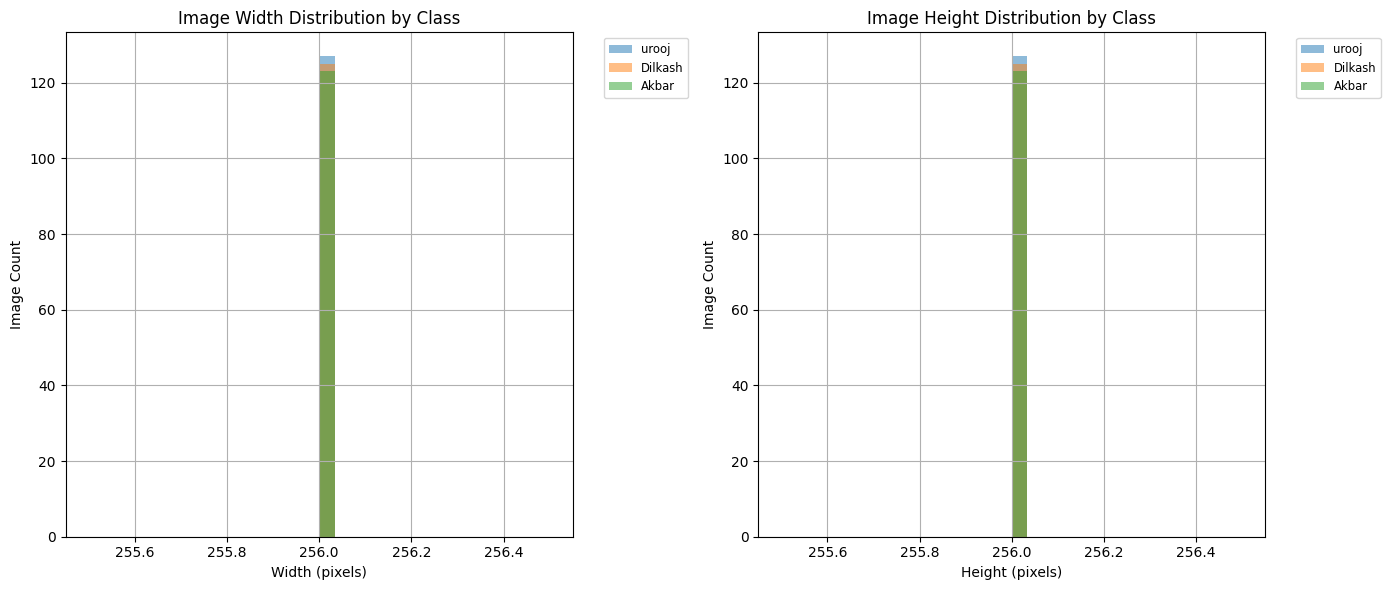

In [27]:
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
for cls in res_df['label'].unique():
    subset = res_df[res_df['label'] == cls]
    plt.hist(subset['width'], bins=30, alpha=0.5, label=cls)
plt.title('Image Width Distribution by Class')
plt.xlabel('Width (pixels)')
plt.ylabel('Image Count')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)


plt.subplot(1, 2, 2)
for cls in res_df['label'].unique():
    subset = res_df[res_df['label'] == cls]
    plt.hist(subset['height'], bins=30, alpha=0.5, label=cls)
plt.title('Image Height Distribution by Class')
plt.xlabel('Height (pixels)')
plt.ylabel('Image Count')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


**Histogram by class based on aspect ratio**

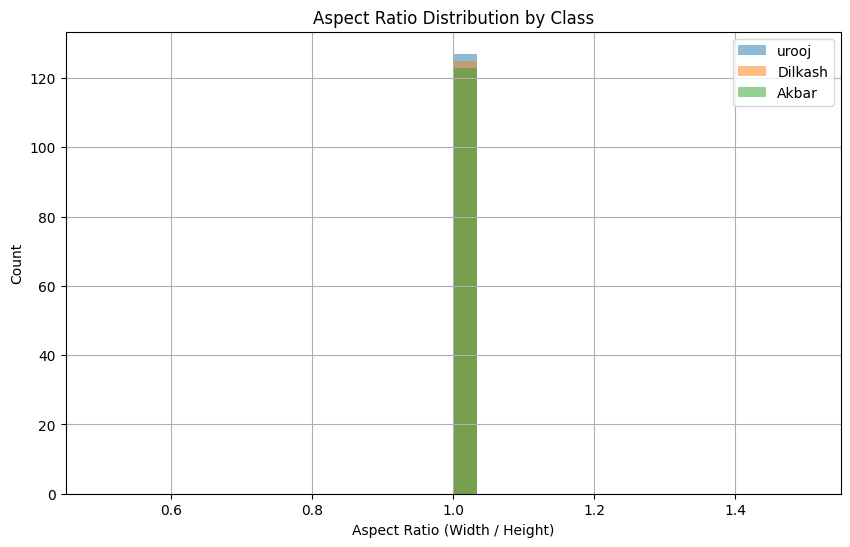

In [26]:
plt.figure(figsize=(10, 6))

for cls in res_df['label'].unique():
    subset = res_df[res_df['label'] == cls]
    plt.hist(subset['aspect_ratio'], bins=30, alpha=0.5, label=cls)

plt.title('Aspect Ratio Distribution by Class')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


**Classwise resizing and padding strategy**

In [37]:
def resize_with_padding(img, target_size):
    target_w, target_h = target_size
    h, w = img.shape[:2]

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized_img = cv2.resize(img, (new_w, new_h))

    delta_w = target_w - new_w
    delta_h = target_h - new_h

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0] 
    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT, value=color)

    return padded_img


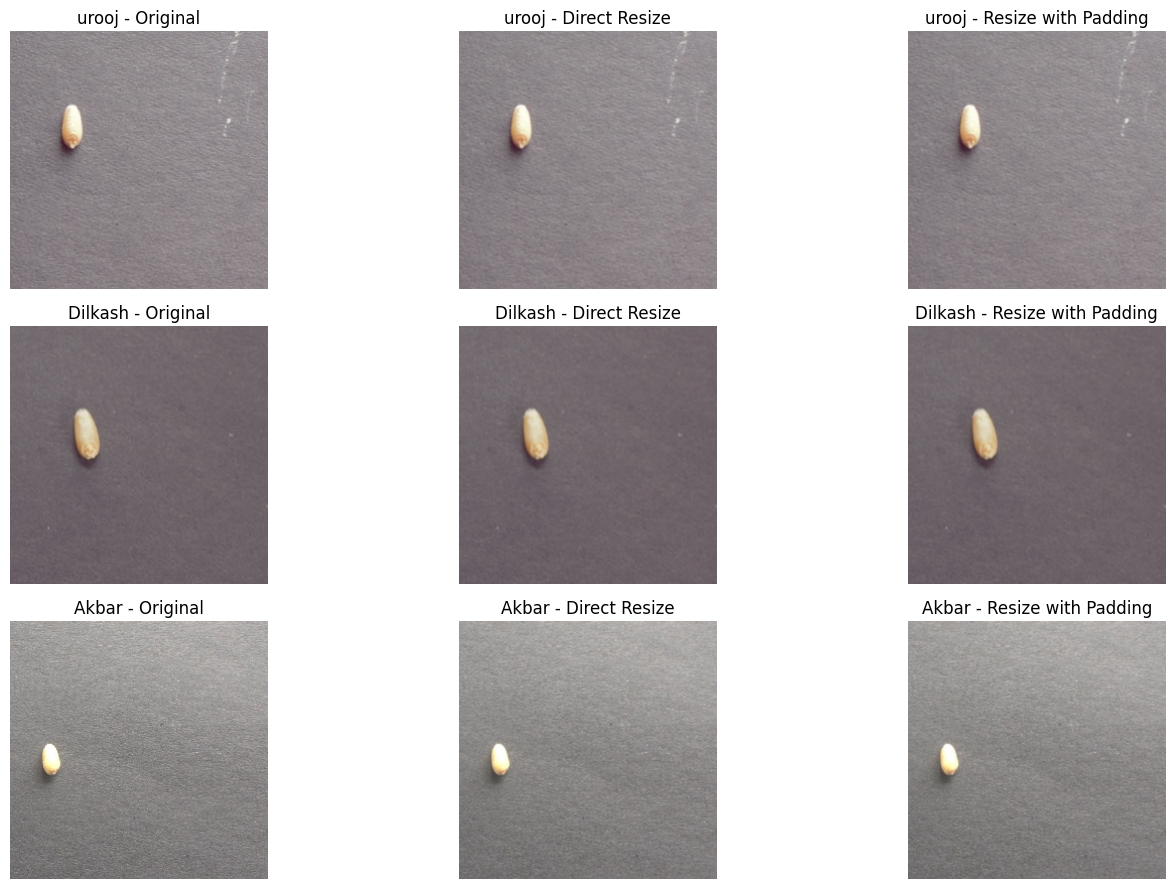

In [40]:
sample_classes = random.sample(list(res_df['label'].unique()), 3)

plt.figure(figsize=(15, 9))

for i, cls in enumerate(sample_classes):
    sample_img_name = res_df[res_df['label'] == cls]['filename'].iloc[0]
    img_path = [p for p in image_paths if os.path.basename(p) == sample_img_name][0]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    direct_resized = cv2.resize(img_rgb, (500, 500))

    padded_resized = resize_with_padding(img_rgb, (500, 500))

    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(img_rgb)
    plt.title(f'{cls} - Original')
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(direct_resized)
    plt.title(f'{cls} - Direct Resize')
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(padded_resized)
    plt.title(f'{cls} - Resize with Padding')
    plt.axis('off')

plt.tight_layout()
plt.show()


> Since all the images are in a uniform square shape (256x256 pixels). There is no effect of resizing and padding


# (III)

In [41]:
def laplacian_variance(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return lap_var


In [42]:
def noise_proxy(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])
    high_freq = cv2.filter2D(gray, -1, kernel)
    return high_freq.std()


In [49]:
sharpness_vals = []
noise_vals = []
labels_list = []

for path in image_paths:
    img = cv2.imread(path)
    sharpness = laplacian_variance(img)
    noise = noise_proxy(img)

    sharpness_vals.append(sharpness)
    noise_vals.append(noise)

    filename = os.path.basename(path)
    label = df.loc[df['image'] == filename, 'label'].values[0]
    labels_list.append(label)

sharp_df = pd.DataFrame({
    'image': [os.path.basename(p) for p in image_paths],
    'label': labels_list,
    'sharpness': sharpness_vals,
    'noise_proxy': noise_vals
})


**Histogram by class based on sharpness**

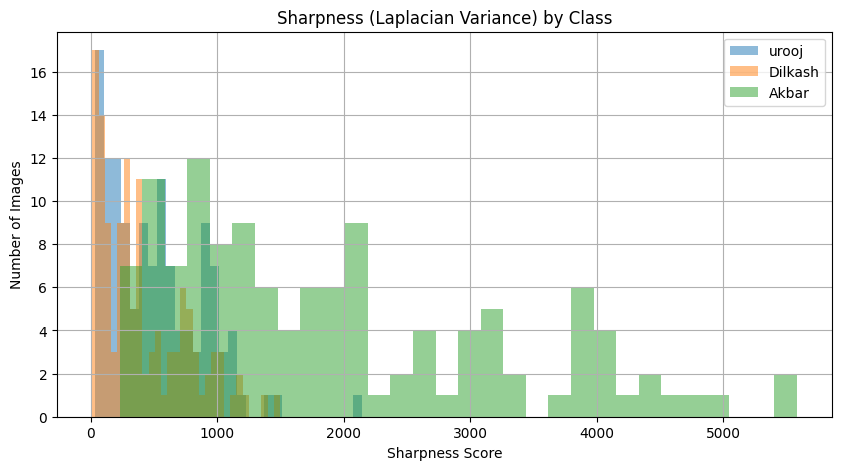

In [51]:
plt.figure(figsize=(10, 5))
for cls in sharp_df['label'].unique():
    plt.hist(sharp_df[sharp_df['label'] == cls]['sharpness'], bins=30, alpha=0.5, label=cls)
plt.title("Sharpness (Laplacian Variance) by Class")
plt.xlabel("Sharpness Score")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(True)
plt.show()


**Histogram by class based on noise proxy**

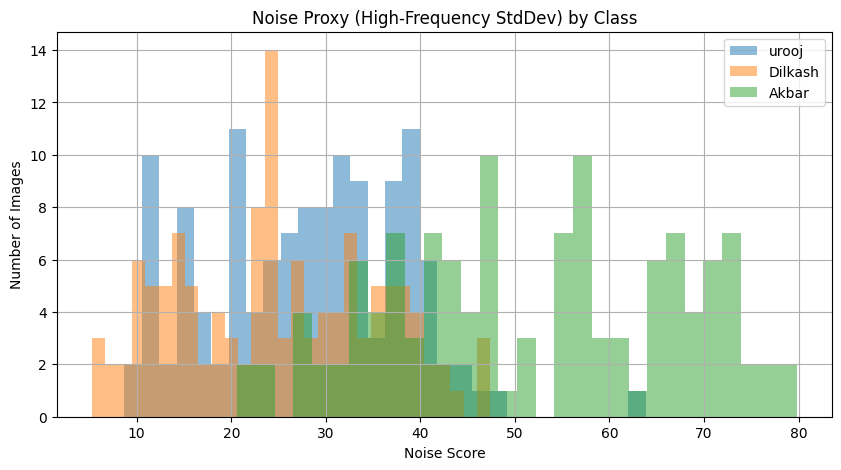

In [52]:
plt.figure(figsize=(10, 5))
for cls in sharp_df['label'].unique():
    plt.hist(sharp_df[sharp_df['label'] == cls]['noise_proxy'], bins=30, alpha=0.5, label=cls)
plt.title("Noise Proxy (High-Frequency StdDev) by Class")
plt.xlabel("Noise Score")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(True)
plt.show()


# (IV)

In [55]:
avg_r_vals = []
avg_g_vals = []
avg_b_vals = []
gray_world_dev = []
labels = []

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    avg_r = np.mean(img[:, :, 0])
    avg_g = np.mean(img[:, :, 1])
    avg_b = np.mean(img[:, :, 2])

    avg_r_vals.append(avg_r)
    avg_g_vals.append(avg_g)
    avg_b_vals.append(avg_b)

    # Deviation from perfect gray (R=G=B)
    mean_rgb = np.mean([avg_r, avg_g, avg_b])
    dev = np.std([avg_r, avg_g, avg_b]) 
    gray_world_dev.append(dev)

    filename = os.path.basename(path)
    label = df.loc[df['image'] == filename, 'label'].values[0]
    labels.append(label)

gray_df = pd.DataFrame({
    'image': [os.path.basename(p) for p in image_paths],
    'label': labels,
    'avg_R': avg_r_vals,
    'avg_G': avg_g_vals,
    'avg_B': avg_b_vals,
    'gray_world_deviation': gray_world_dev
})


**Histogram by class based on gray world deviation**

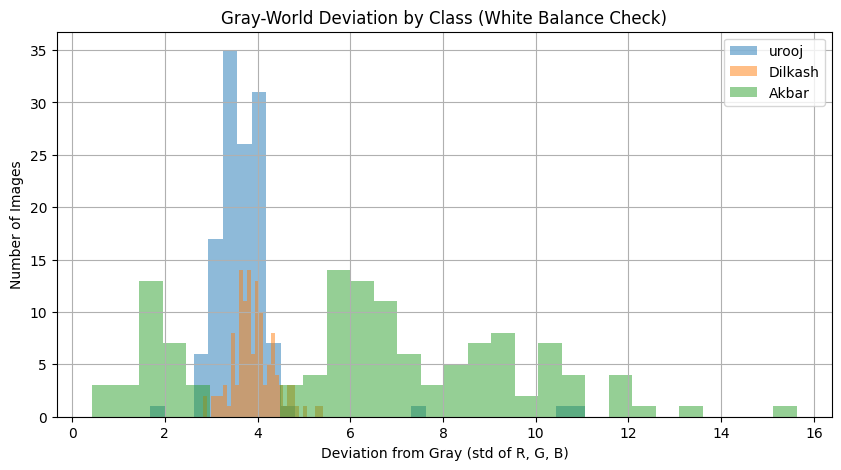

In [56]:
plt.figure(figsize=(10, 5))
for cls in gray_df['label'].unique():
    plt.hist(gray_df[gray_df['label'] == cls]['gray_world_deviation'], bins=30, alpha=0.5, label=cls)
plt.title("Gray-World Deviation by Class (White Balance Check)")
plt.xlabel("Deviation from Gray (std of R, G, B)")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(True)
plt.show()


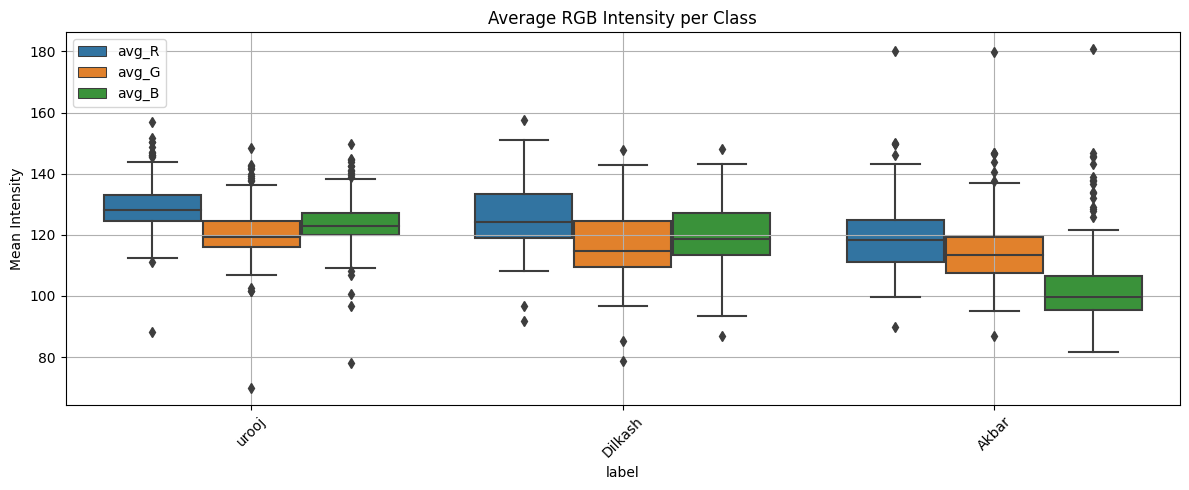

In [57]:
import seaborn as sns

plt.figure(figsize=(12, 5))
gray_melted = gray_df.melt(id_vars='label', value_vars=['avg_R', 'avg_G', 'avg_B'],
                           var_name='Channel', value_name='Mean Intensity')
sns.boxplot(x='label', y='Mean Intensity', hue='Channel', data=gray_melted)
plt.title("Average RGB Intensity per Class")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# (V)

In [59]:
hashes = []
hash_paths = []
labels = []

for path in image_paths:
    img = Image.open(path)
    hash_val = imagehash.phash(img)  # perceptual hash (64-bit)
    hashes.append(hash_val)
    hash_paths.append(path)
    filename = os.path.basename(path)
    label = df.loc[df['image'] == filename, 'label'].values[0]
    labels.append(label)

phash_df = pd.DataFrame({
    'path': hash_paths,
    'hash': hashes,
    'label': labels
})


In [73]:
duplicate_pairs = []


for (i1, row1), (i2, row2) in combinations(phash_df.iterrows(), 2):
    dist = row1['hash'] - row2['hash'] 
    if dist <= 3:  
        duplicate_pairs.append((row1['path'], row2['path'], dist))
print(f"Found {len(duplicate_pairs)} potential duplicate pairs (Hamming dist ≤ 3).")


Found 85 potential duplicate pairs (Hamming dist ≤ 3).


**Show duplicates**

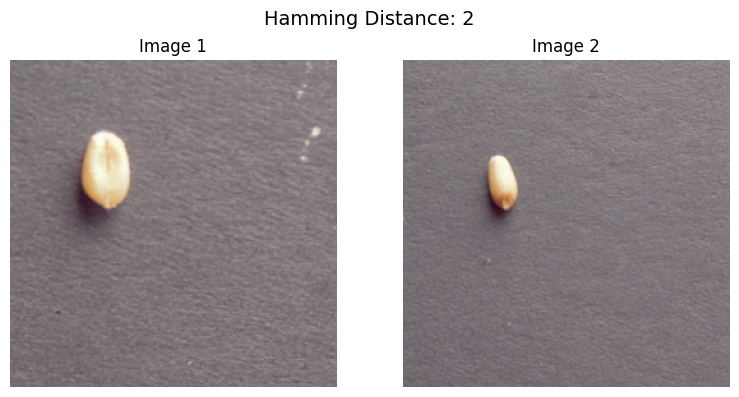

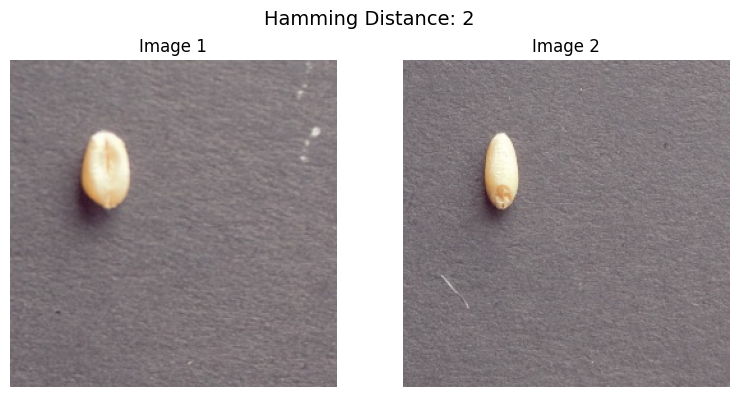

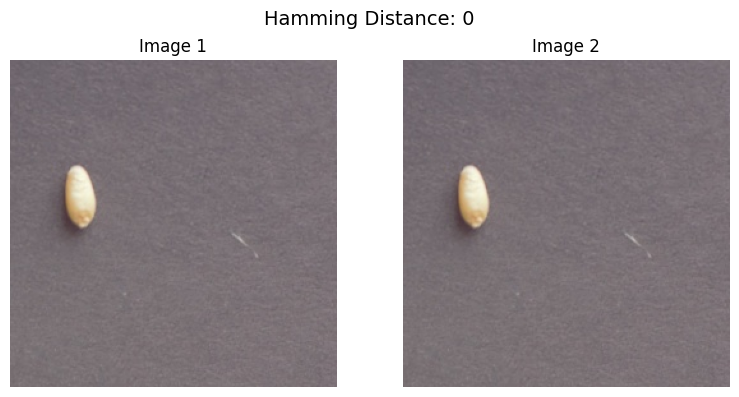

In [74]:
def show_duplicates(pairs, n):
    for i in range(min(n, len(pairs))):
        p1, p2, dist = pairs[i]
        img1 = cv2.cvtColor(cv2.imread(p1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(p2), cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 4))
        plt.suptitle(f"Hamming Distance: {dist}", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title("Image 1")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title("Image 2")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

show_duplicates(duplicate_pairs, n=3)


# NO need for (VI) . Already balanced

# (VI)

**Safeguarding during splitting**

In [77]:
image_paths = []
labels = []
groups = []

root_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    if not os.path.isdir(class_path):
        continue
    for subdir in os.listdir(class_path):
        subdir_path = os.path.join(class_path, subdir)
        if not os.path.isdir(subdir_path):
            continue
        for file in os.listdir(subdir_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir_path, file)
                image_paths.append(img_path)
                labels.append(class_dir)
                groups.append(subdir)  


splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(image_paths, groups=groups))

train_paths = [image_paths[i] for i in train_idx]
val_paths = [image_paths[i] for i in val_idx]

print(f"Train: {len(train_paths)}, Validation: {len(val_paths)}")


Train: 300, Validation: 75


**Augmentation probe**

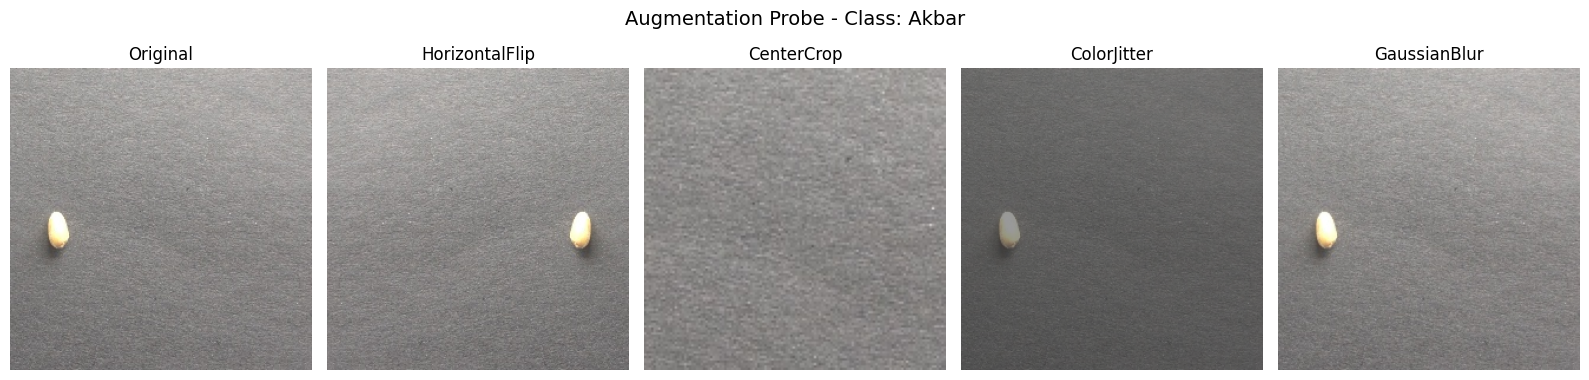

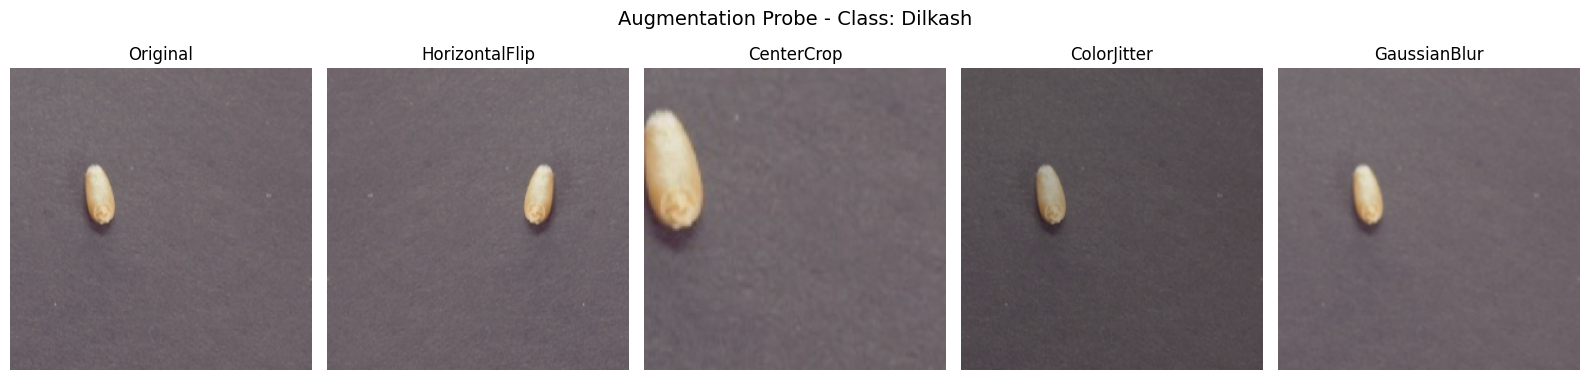

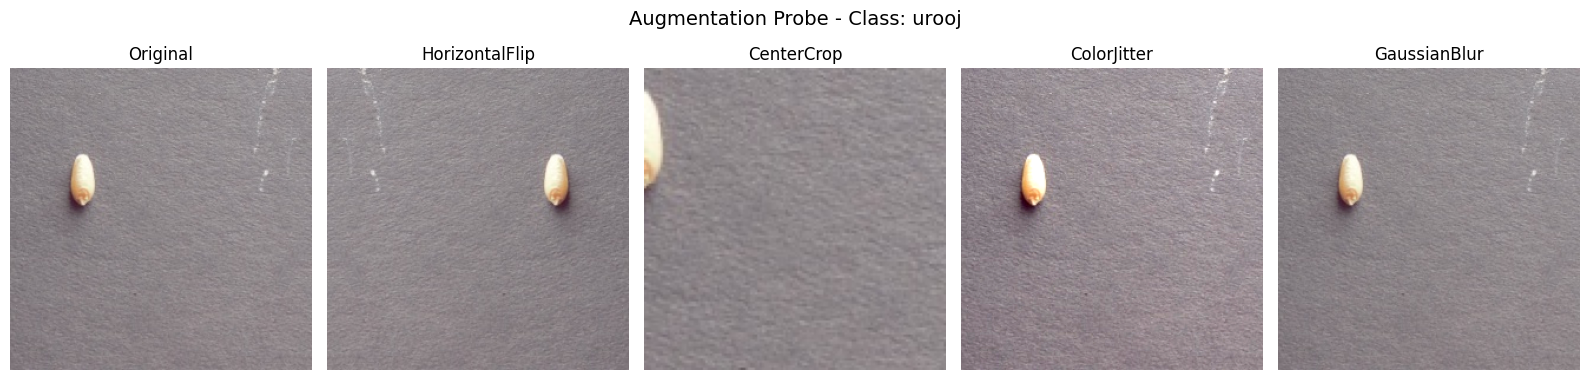

In [84]:
root_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"


augmentations = {
    'HorizontalFlip': T.RandomHorizontalFlip(p=1.0),
    'CenterCrop': T.CenterCrop(128),
    'ColorJitter': T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    'GaussianBlur': T.GaussianBlur(kernel_size=5)
}

sample_images = []

for class_dir in sorted(os.listdir(root_dir)):
    class_path = os.path.join(root_dir, class_dir)
    if not os.path.isdir(class_path):
        continue
    for subdir in os.listdir(class_path):
        subdir_path = os.path.join(class_path, subdir)
        if not os.path.isdir(subdir_path):
            continue
        for file in os.listdir(subdir_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(subdir_path, file)
                sample_images.append((class_dir, img_path))  
                break  
        break  
    if len(sample_images) == 3:
        break  

for cls_name, img_path in sample_images:
    original = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Augmentation Probe - Class: {cls_name}", fontsize=14)

    plt.subplot(1, len(augmentations) + 1, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    for i, (name, aug) in enumerate(augmentations.items(), 2):
        transformed = aug(original)
        plt.subplot(1, len(augmentations) + 1, i)
        plt.imshow(transformed)
        plt.title(name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


> The only augmentation that is clearly harmful is center crop. If the center crop is dimension is too low, it may not even keep the object in focus. Gausian blurs effect also differs based on how zoomed in the photo is. Horizontal flip seems useless if the position of the object in image is not fixed. The model will see objects in different position nonethless even if we don't use HorizontalFlip